#### **Training Llama2 with LORA on ALPACA Dataset**

based on https://gist.github.com/radekosmulski/c3cce1a52b52b9b2037e1941de5afa32 from Radek Osmulski

#### **Fine-Tuning Llama 2 with LoRA on the ALPACA Dataset**

This Jupyter Notebook demonstrates the process of **fine-tuning** the powerful **Llama 2 (7B)** large language model using the **Low-Rank Adaptation (LoRA)** technique on the **Stanford Alpaca dataset**.

The goal is to efficiently adapt the pre-trained Llama 2 model to follow instructions and generate responses similar to the Alpaca model, while minimizing computational costs and memory usage.

#### Key Technologies Used

* **Llama 2 (7B-hf):** The base large language model from Meta.
* **LoRA (Low-Rank Adaptation):** A parameter-efficient fine-tuning (PEFT) method that drastically reduces the number of trainable parameters, making fine-tuning feasible on consumer-grade GPUs (like the NVIDIA RTX 3090).
* **Hugging Face `transformers` and `datasets`:** Used for loading the model, tokenizer, and the Alpaca training data.
* **Hugging Face `peft`:** Provides the necessary utilities to apply the LoRA configuration to the Llama 2 model.
* **Hugging Face `accelerate`:** Used to manage mixed-precision training (`bf16`) and gradient accumulation, which are crucial for stable and efficient training of large models.

#### Steps in the Notebook

1.  **Setup and Data Loading:** Import necessary libraries, specify the GPU, load the `Llama-2-7b-hf` model and tokenizer, and fetch the `tatsu-lab/alpaca` dataset.
2.  **Preprocessing and Tokenization:** Implement a custom function (`process_example`) to format the Alpaca instructions/inputs into the prompt template expected by the model. A custom `SupervisedDataset` class handles tokenization and filtering of excessively long examples.
3.  **Model Configuration (LoRA):** Apply the LoRA configuration using `get_peft_model`, showing how only a small percentage of parameters become trainable.
4.  **Training Setup:** Define the `DataLoader`s and set up the `AdamW` optimizer and `OneCycleLR` scheduler. The `accelerator` prepares these components for training.
5.  **Training Loop:** The core training loop iterates over the dataset for a set number of epochs, performing forward and backward passes, accumulating gradients, and updating the model weights using the LoRA adapters.
6.  **Evaluation and Saving:** The notebook includes steps to evaluate the model's loss and token accuracy on a validation set, and finally, saves the fine-tuned LoRA weights.

In [1]:
import copy
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence
import warnings

from tqdm import tqdm
from pdb import set_trace
import os
from dotenv import load_dotenv

import torch
import numpy as np
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from matplotlib import pyplot as plt

from datasets import load_dataset, DatasetDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available")

GPU name: NVIDIA GB10


/home/jaume/DL/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


In [2]:
# load secret tokens

load_dotenv("../secrets.env")  # This reads the .env file
HF_token = os.getenv("HUGGING_FACE_token")

In [3]:
# upload Standford Alpaca dataset from datasets
dataset = load_dataset("tatsu-lab/alpaca")

In [4]:
# upload Llama from Meta
model_name = 'meta-llama/Llama-2-7b-hf'
model = AutoModelForCausalLM.from_pretrained(
        model_name, 
        token=HF_token,
        dtype=torch.bfloat16,                       # trying to reduce space as it reaches GPU mem limit easily
        cache_dir="./.cache/huggingface")
tokenizer = AutoTokenizer.from_pretrained(
        model_name, 
        token=HF_token,
        cache_dir="./.cache/huggingface")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
datasets = dataset['train'].train_test_split(test_size=2002, seed=42)
datasets = DatasetDict({'train': datasets['train'], 'valid': datasets['test']})

In [6]:
# code from Stanford Alpaca https://github.com/tatsu-lab/stanford_alpaca

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def smart_tokenizer_and_embedding_resize(
    special_tokens_dict: Dict,
    tokenizer: transformers.PreTrainedTokenizer,
    model: transformers.PreTrainedModel,
):
    """Resize tokenizer and embedding.

    Note: This is the unoptimized version that may make your embedding size not be divisible by 64.
    """
    num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
    model.resize_token_embeddings(len(tokenizer))

    if num_new_tokens > 0:
        input_embeddings = model.get_input_embeddings().weight.data
        output_embeddings = model.get_output_embeddings().weight.data

        input_embeddings_avg = input_embeddings[:-num_new_tokens].mean(dim=0, keepdim=True)
        output_embeddings_avg = output_embeddings[:-num_new_tokens].mean(dim=0, keepdim=True)

        input_embeddings[-num_new_tokens:] = input_embeddings_avg
        output_embeddings[-num_new_tokens:] = output_embeddings_avg
        
special_tokens_dict = dict()
special_tokens_dict["pad_token"] = "[PAD]"

smart_tokenizer_and_embedding_resize(special_tokens_dict, tokenizer, model)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [7]:
tokenizer.encode('[PAD]')

[1, 32000]

In [8]:
tokenizer.decode([32000])

'[PAD]'

In [9]:
class SupervisedDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        discarded_examples_count = 0
        self.examples = []
        for example in tqdm(dataset):
            input_ids, labels = process_example(example)
            if input_ids.shape[0] > 512:
                discarded_examples_count += 1
            else:
                self.examples.append((input_ids, labels))
        print(f'Discarded {discarded_examples_count} examples due to length > 512.')
            
    def __getitem__(self, idx):
        return {"input_ids": self.examples[idx][0], "labels": self.examples[idx][1]}
    def __len__(self):
        return len(self.examples)

In [10]:
def process_example(example):
    template = PROMPT_DICT["prompt_input"]
    if not example['input']:
        template = PROMPT_DICT["prompt_no_input"] + '\n\n'

    prompt = template.format_map(example)
    prompt_toks = tokenizer(prompt)['input_ids']
    input_ids = tokenizer(prompt + example["output"] + tokenizer.eos_token, return_tensors='pt')['input_ids'][0]
    labels = input_ids.clone().detach()
    labels[:len(prompt_toks)] = -100 # loss will not be calculated for labels set to -100
    return input_ids, labels

In [11]:
train_ds = SupervisedDataset(datasets['train'])
valid_ds = SupervisedDataset(datasets['valid'])

100%|██████████| 50000/50000 [00:13<00:00, 3795.35it/s]


Discarded 94 examples due to length > 512.


100%|██████████| 2002/2002 [00:00<00:00, 3832.37it/s]

Discarded 3 examples due to length > 512.


In [12]:
def collate_fn(examples):
    input_ids, labels = tuple([example[key] for example in examples] for key in ("input_ids", "labels"))
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    return dict(
        input_ids=input_ids,
        labels=labels,
        attention_mask=input_ids.ne(tokenizer.pad_token_id)
    )

In [13]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
   

In [14]:
from peft import LoraConfig, TaskType
from peft import get_peft_model

peft_config = LoraConfig(task_type=TaskType.CAUSAL_LM, 
                         inference_mode=False, 
                         r=8, 
                         lora_alpha=32, 
                         lora_dropout=0.1)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 4,194,304 || all params: 6,742,618,112 || trainable%: 0.0622


In [15]:
train_batch_size = 8  # should be 6 Careful GPU Memory is easily overuned
lr = 4e-4
num_epochs = 3

In [16]:
from accelerate import Accelerator

accelerator = Accelerator(mixed_precision='bf16', gradient_accumulation_steps=128//train_batch_size)

In [17]:
train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=2*train_batch_size, shuffle=False, collate_fn=collate_fn)

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dl)
)

In [19]:
model, train_dl, valid_dl, optimizer, lr_scheduler = accelerator.prepare(
    model, train_dl, valid_dl, optimizer, lr_scheduler
)

In [20]:
lrs = []
train_losses = []

In [21]:
next(model.parameters()).dtype

torch.bfloat16

In [22]:
set([p.dtype for p in model.parameters()])

{torch.bfloat16, torch.float32}

In [23]:
#original
# Do this in a terminal watch -n0.3 nvidia-smi
for i in range(num_epochs):
    model.train()
    pbar = tqdm(train_dl, leave=True)
    for batch in pbar:

        outputs = model(**batch)
        loss = outputs.loss

        train_losses.append(loss.item())
        lrs.append(optimizer.param_groups[0]['lr'])

        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()
        pbar.set_description(f'Epoch: {i:2d}\tTrain loss: {np.mean(train_losses[-20:]) :.2f}')

    model.eval()
    preds = []
    labels = []
    val_losses = []
    for batch in tqdm(valid_dl, leave=False):
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        val_losses.append(outputs.loss.item())

        preds.append(outputs.logits.argmax(-1).cpu().detach())
        labels.append(batch['labels'].cpu().detach())

    hits = 0
    chances = 0
    for p, l in zip(preds, labels):
        hits += (p == l).sum().item()
        chances += (l != -100).sum().item()
    print(f'Val loss: {np.mean(val_losses):3.02f}\ttoken accuracy: {hits/chances:3.02f}')

Epoch:  0	Train loss: 1.06: 100%|██████████| 6239/6239 [2:20:57<00:00,  1.36s/it]  
                                                 

Val loss: 1.08	token accuracy: 0.00


Epoch:  1	Train loss: 1.06: 100%|██████████| 6239/6239 [2:20:56<00:00,  1.36s/it]  
                                                 

Val loss: 1.06	token accuracy: 0.00


Epoch:  2	Train loss: 1.00: 100%|██████████| 6239/6239 [2:21:06<00:00,  1.36s/it]  
                                                 

Val loss: 1.07	token accuracy: 0.00


In [24]:
model.save_pretrained('./models/lora_apaca_llama2')

/home/jaume/DL/lib/python3.12/site-packages/peft/utils/other.py:1394: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-693d8d94-7628b7530f21f6f96406060d;7c2ff33a-77f9-47f9-8ff1-8757a2d2dfb8)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-hf is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Llama-2-7b-hf.
  warnings.warn(
/home/jaume/DL/lib/python3.12/site-packages/peft/utils/save_and_load.py:295: UserWarning: Could not find a config file in meta-llama/Llama-2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(


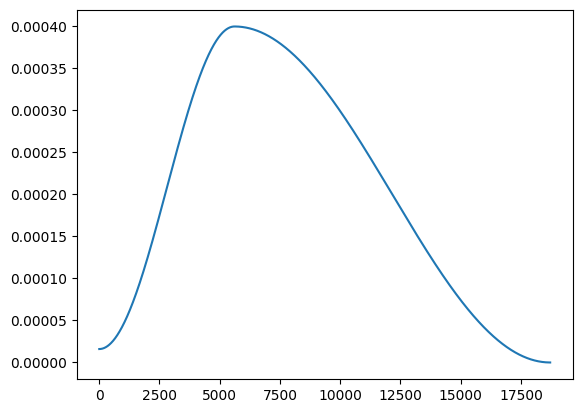

In [25]:
plt.plot(lrs)

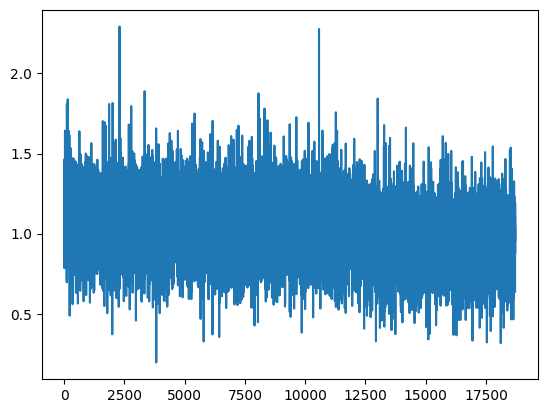

In [26]:
plt.plot(train_losses)